In [1]:
# Dependencies
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [6]:
# Load in data
uni_ar_lstm = pd.read_csv('uni_ar_lstm.csv') # univariate autoregressive lstm
lstm = pd.read_csv('lstm.csv') # lstm
ar = pd.read_csv('ar.csv') # autoregressive
var = pd.read_csv('var.csv') # vector autoregressive
var = var[var['rmse'] < 5]

# Get the minimum error for each forecast horizon
uni_ar_lstm_min = uni_ar_lstm.groupby('forecast_horizon')['rmse'].min().reset_index()
lstm_min = lstm.groupby('forecast_horizon')['rmse'].min().reset_index()
ar_min = ar.groupby('forecast_horizon')['rmse'].min().reset_index()
var_min = var.groupby('forecast_horizon')['rmse'].min().reset_index()

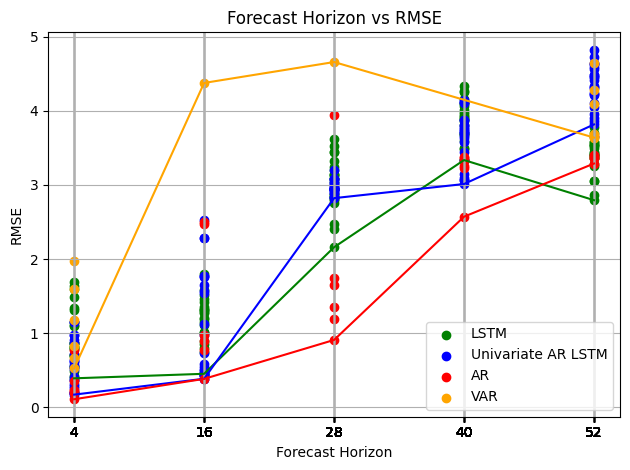

In [9]:
# Visualize minimum RMSE at each forecast horizon
plt.figure()
# Plot the RMSE for each model
plt.scatter(lstm['forecast_horizon'], lstm['rmse'], marker='o', label="LSTM", color="green")
plt.scatter(uni_ar_lstm['forecast_horizon'], uni_ar_lstm['rmse'], marker='o', label="Univariate AR LSTM", color="blue")
plt.scatter(ar['forecast_horizon'], ar['rmse'], marker='o', label="AR", color="red")
plt.scatter(var['forecast_horizon'], var['rmse'], marker='o', label="VAR", color="orange")
# Plot the minimum RMSE for each model
plt.plot(lstm_min['forecast_horizon'], lstm_min['rmse'], color='green')
plt.plot(uni_ar_lstm_min['forecast_horizon'], uni_ar_lstm_min['rmse'], color='blue')
plt.plot(ar_min['forecast_horizon'], ar_min['rmse'], color='red')
plt.plot(var_min['forecast_horizon'], var_min['rmse'], color='orange')

plt.title('Forecast Horizon vs RMSE')
plt.xlabel('Forecast Horizon')
plt.ylabel('RMSE')
plt.xticks(lstm['forecast_horizon'])
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

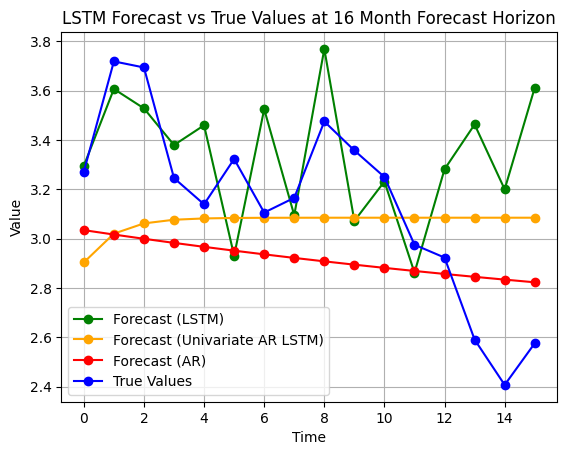

In [11]:
# Plot lstm forecast of minimum error at 4 forecast horizon
inflation_index = pd.read_csv('../current.csv', index_col=0)[1:].dropna()["CPIAUCSL"].index

lstm_data = lstm[lstm['forecast_horizon'] == 16]
lstm_data = lstm_data[lstm_data['rmse'] == lstm_data['rmse'].min()]
lstm_forecast = np.array(eval(lstm_data['forecast'].values[0]))
actual = np.array(eval(lstm_data['actual'].values[0]))

# Get uni ar lstm data
uni_ar_lstm_data = uni_ar_lstm[uni_ar_lstm['forecast_horizon'] == 16]
uni_ar_lstm_data = uni_ar_lstm_data[uni_ar_lstm_data['rmse'] == uni_ar_lstm_data['rmse'].min()] 
uni_forecast = np.array(eval(uni_ar_lstm_data['forecast'].values[0]))

# Get AR data
ar_data = ar[ar['forecast_horizon'] == 16]
ar_data = ar_data[ar_data['rmse'] == ar_data['rmse'].min()]
ar_forecast = np.array(eval(ar_data['forecast'].values[0]))

# VAR data
var_data = var[var['forecast_horizon'] == 16]
var_data = var_data[var_data['rmse'] == var_data['rmse'].min()]
var_forecast = np.array(eval(var_data['forecast'].values[0]))
actual = np.array(eval(var_data['actual'].values[0]))

plt.figure()
plt.plot(lstm_forecast, label='Forecast (LSTM)', color='green', marker='o')
plt.plot(uni_forecast, label='Forecast (Univariate AR LSTM)', color='orange', marker='o')
plt.plot(ar_forecast, label='Forecast (AR)', color='red', marker='o')
plt.plot(actual, label='True Values', color='blue', marker='o')
plt.title('LSTM Forecast vs True Values at 16 Month Forecast Horizon')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.grid()
plt.show()

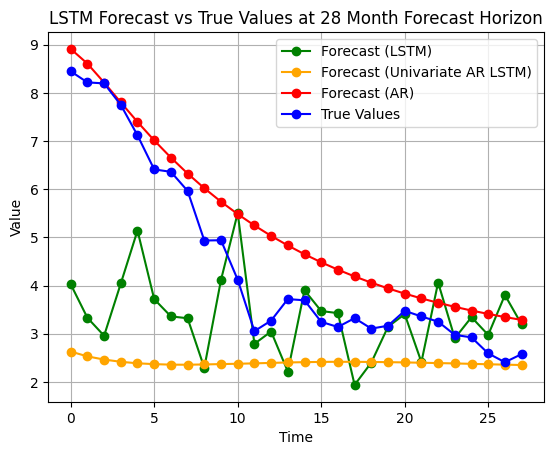

In [12]:
# Plot lstm forecast of minimum error at 28 month forecast horizon
inflation_index = pd.read_csv('../current.csv', index_col=0)[1:].dropna()["CPIAUCSL"].index

lstm_data = lstm[lstm['forecast_horizon'] == 28]
lstm_data = lstm_data[lstm_data['rmse'] == lstm_data['rmse'].min()]
lstm_forecast = np.array(eval(lstm_data['forecast'].values[0]))
actual = np.array(eval(lstm_data['actual'].values[0]))

# Get uni ar lstm data
uni_ar_lstm_data = uni_ar_lstm[uni_ar_lstm['forecast_horizon'] == 28]
uni_ar_lstm_data = uni_ar_lstm_data[uni_ar_lstm_data['rmse'] == uni_ar_lstm_data['rmse'].min()] 
uni_forecast = np.array(eval(uni_ar_lstm_data['forecast'].values[0]))

# Get AR data
ar_data = ar[ar['forecast_horizon'] == 28]
ar_data = ar_data[ar_data['rmse'] == ar_data['rmse'].min()]
ar_forecast = np.array(eval(ar_data['forecast'].values[0]))

plt.figure()
plt.plot(lstm_forecast, label='Forecast (LSTM)', color='green', marker='o')
plt.plot(uni_forecast, label='Forecast (Univariate AR LSTM)', color='orange', marker='o')
plt.plot(ar_forecast, label='Forecast (AR)', color='red', marker='o')
plt.plot(actual, label='True Values', color='blue', marker='o')
plt.title('LSTM Forecast vs True Values at 28 Month Forecast Horizon')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.grid()
plt.show()

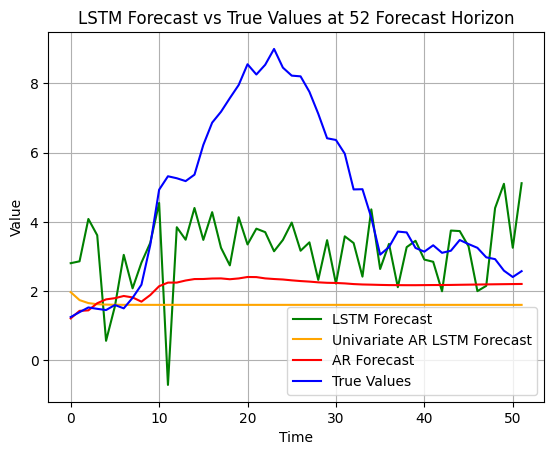

In [5]:
# Plot lstm forecast of minimum error at 52 forecast horizon
inflation_index = pd.read_csv('../current.csv', index_col=0)[1:].dropna()["CPIAUCSL"].index

data = lstm[lstm['forecast_horizon'] == 52]
data = data[data['rmse'] == data['rmse'].min()]
forecast = np.array(eval(data['forecast'].values[0]))
actual = np.array(eval(data['actual'].values[0]))

other_data = uni_ar_lstm[uni_ar_lstm['forecast_horizon'] == 52]
uni_ar_lstm_data = other_data[other_data['rmse'] == other_data['rmse'].min()]
uni_ar_lstm_forecast = np.array(eval(uni_ar_lstm_data['forecast'].values[0]))

# Get AR data
ar_data = ar[ar['forecast_horizon'] == 52]
ar_data = ar_data[ar_data['rmse'] == ar_data['rmse'].min()]
ar_forecast = np.array(eval(ar_data['forecast'].values[0]))

plt.figure()
plt.plot(forecast, label='LSTM Forecast', color='green')
plt.plot(uni_ar_lstm_forecast, label='Univariate AR LSTM Forecast', color='orange')
plt.plot(ar_forecast, label='AR Forecast', color='red')
plt.plot(actual, label='True Values', color='blue')
plt.title('LSTM Forecast vs True Values at 52 Forecast Horizon')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.grid()
plt.show()

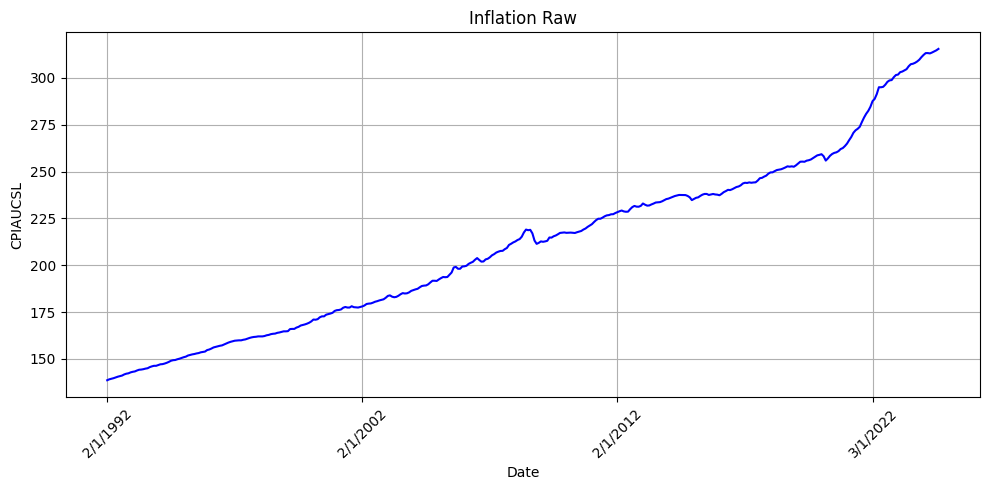

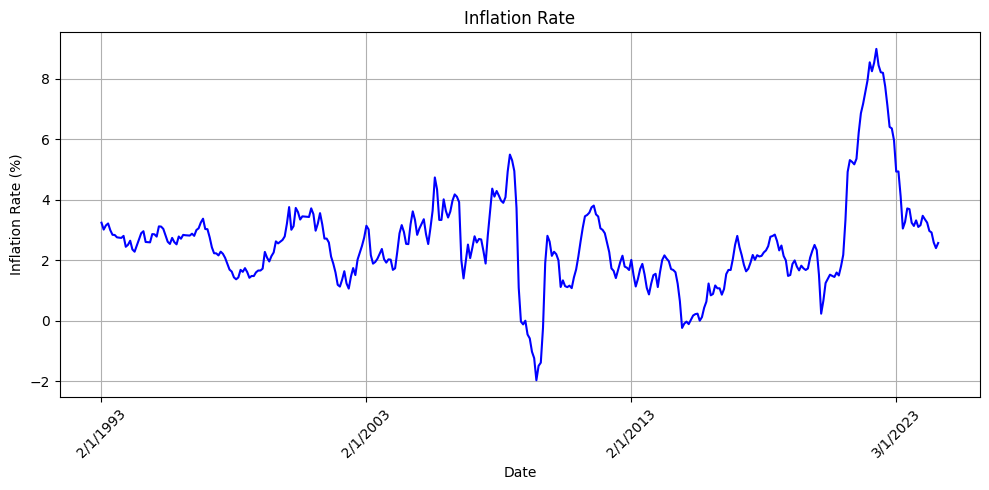

In [20]:
import matplotlib.dates as mdates

# Visualize inflation 
inflation_raw = pd.read_csv('../current.csv', index_col=0)[1:].dropna()["CPIAUCSL"]
inflation_rate = (inflation_raw.pct_change(periods=12) * 100).dropna()

# Plot inflation raw
plt.figure(figsize=(10, 5))
plt.plot(inflation_raw, color='blue')
plt.title('Inflation Raw')
plt.xlabel('Date')
plt.ylabel('CPIAUCSL')
# Show a label every 10 years
x_labels = [inflation_raw.index[i] for i in range(0, len(inflation_raw), 120)]
plt.xticks(x_labels, rotation=45)
plt.grid()
plt.tight_layout()
plt.show()
plt.close()

# Plot inflation rate
plt.figure(figsize=(10, 5))
plt.plot(inflation_rate, color='blue')
plt.title('Inflation Rate')
plt.xlabel('Date')
plt.ylabel('Inflation Rate (%)')
# Format x-axis
x_labels = [inflation_rate.index[i] for i in range(0, len(inflation_rate), 120)]
plt.xticks(x_labels, rotation=45)
plt.xticks(rotation=45)
plt.grid()
plt.tight_layout()
plt.show()
plt.close()